<a href="https://colab.research.google.com/github/slavyolov/Algorithms/blob/main/Anomaly_detection_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PCA

### Usage :
- Anonimyze data - https://www.atmosera.com/blog/pca-based-anomaly-detection/

### PCA anomaly detection :
- https://andrewm4894.com/2021/10/11/time-series-anomaly-detection-using-pca/
  - https://github.com/andrewm4894/colabs/blob/master/time_series_anomaly_detection_with_pca.ipynb
- https://www.atmosera.com/blog/pca-based-anomaly-detection/
  - binary classifier | https://github.com/jeffprosise/Machine-Learning/blob/master/Fraud%20Detection%20(Supervised).ipynb
  - PCA #1 | https://github.com/jeffprosise/Machine-Learning/blob/master/Fraud%20Detection%20(Unsupervised).ipynb
  - PCA #2 | https://github.com/jeffprosise/Machine-Learning/blob/master/Anomaly%20Detection%20(PCA).ipynb
### Raw data : 
- public data from a demo server at Netdata Cloud

### Features : 
- https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [ ]:
!pip install netdata_pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 358 kB 8.6 MB/s 
     |████████████████████████████████| 58 kB 5.4 MB/s 
     |████████████████████████████████| 80 kB 8.5 MB/s 
  Created wheel for asks: filename=asks-3.0.0-py3-none-any.whl size=25707 sha256=45ebbb3450331bf85e5a8b047c54f1ab46c8381f42ee480aebe861ba6be07480
  Stored in directory: /root/.cache/pip/wheels/c0/b9/a5/c3817d576ca6277fac352782a6a7ba5fee25e4d6db9d9bd278
Successfully built asks
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

from netdata_pandas.data import get_data

/usr/local/lib/python3.7/dist-packages/trio/_core/_multierror.py:464: RuntimeWarning: IPython detected, but you already have a custom exception handler installed. I'll skip installing Trio's custom handler, but this means MultiErrors will not show full tracebacks.
  category=RuntimeWarning,


In [ ]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

from netdata_pandas.data import get_data


def anomaly_scores(pca, X):
    """Given a fitted pca model and some X feature vectors, compute an anomaly score as the sum of weighted euclidean distance between each sample to the
    hyperplane constructed by the selected eigenvectors. 
    """
    return np.sum(cdist(X, pca.components_) / pca.explained_variance_ratio_, axis=1).ravel()


def preprocess_df(df, lags_n, diffs_n, smooth_n, diffs_abs=False, abs_features=True):
    """Given a pandas dataframe preprocess it to take differences, add smoothing, and lags as specified. 
    """
    if diffs_n >= 1:
        # take differences
        df = df.diff(diffs_n).dropna()
        # abs diffs if defined
        if diffs_abs == True:
            df = abs(df)
    if smooth_n >= 2:
        # apply a rolling average to smooth out the data a bit
        df = df.rolling(smooth_n).mean().dropna()
    if lags_n >= 1:
        # for each dimension add a new columns for each of lags_n lags of the differenced and smoothed values for that dimension
        df_columns_new = [f'{col}_lag{n}' for n in range(lags_n+1) for col in df.columns]
        df = pd.concat([df.shift(n) for n in range(lags_n + 1)], axis=1).dropna()
        df.columns = df_columns_new
    # sort columns to have lagged values next to each other for clarity when looking at the feature vectors
    df = df.reindex(sorted(df.columns), axis=1)

    # abs all features if specified
    if abs_features == True:
        df = abs(df)
    
    return df

In [ ]:
# inputs 
host = 'london.my-netdata.io'  # pull from 'london' netdata demo host
after = -3600  # last 60 minutes
before = 0  # starting from now
dims = ['system.cpu|system']  # lets just look at system cpu data

# params
n_train = 3000  # use the last 50 minutes of data to train on
diffs_n = 1  # take differences
lags_n = 3  # include 3 lags in the feature vector
smooth_n = 3  # smooth the latest values to be included in the feature vector

In [ ]:
# get raw data
df = get_data(
    hosts=[host], 
    charts=list(set([d.split('|')[0] for d in dims])), 
    after=after, 
    before=before, 
    index_as_datetime=True
)
df = df[dims]

# look at raw data
print(df.shape)
display(df.head())

(3600, 1)


,system.cpu|system
time_idx,
2022-08-16 05:52:21,0.502513
2022-08-16 05:52:22,0.502513
2022-08-16 05:52:23,0.503778
2022-08-16 05:52:24,0.503778
2022-08-16 05:52:25,0.251889


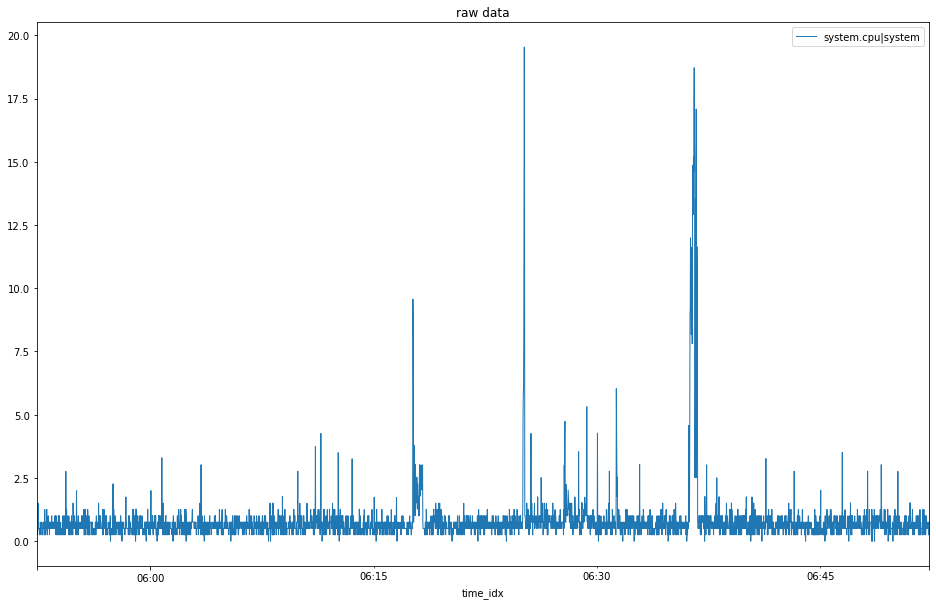

In [ ]:
# plot the raw data
df.plot(title='raw data', figsize=(16,10), lw=1)

****************************************************************************************************
preprocessing parameters
****************************************************************************************************
diffs_n == 1
lags_n == 3
smooth_n == 3
****************************************************************************************************

****************************************************************************************************
train_data DF 


,system.cpu|system
time_idx,
2022-08-16 05:52:21,0.502513
2022-08-16 05:52:22,0.502513
2022-08-16 05:52:23,0.503778
2022-08-16 05:52:24,0.503778
2022-08-16 05:52:25,0.251889
...,...
2022-08-16 06:42:16,0.751880
2022-08-16 06:42:17,0.503778
2022-08-16 06:42:18,1.002506


****************************************************************************************************

****************************************************************************************************
train_data DF 


,system.cpu|system_lag0,system.cpu|system_lag1,system.cpu|system_lag2,system.cpu|system_lag3
time_idx,,,,
2022-08-16 05:52:27,4.219000e-04,1.259433e-03,0.083541,0.000422
2022-08-16 05:52:28,4.147901e-01,4.219000e-04,0.001259,0.083541
2022-08-16 05:52:29,8.375333e-04,4.147901e-01,0.000422,0.001259
2022-08-16 05:52:30,1.850372e-17,8.375333e-04,0.414790,0.000422
2022-08-16 05:52:31,3.312489e-01,1.850372e-17,0.000838,0.414790
...,...,...,...,...
2022-08-16 06:42:16,1.664515e-01,1.654072e-01,0.000422,0.000633
2022-08-16 06:42:17,4.219000e-04,1.664515e-01,0.165407,0.000422
2022-08-16 06:42:18,1.662427e-01,4.219000e-04,0.166451,0.165407


****************************************************************************************************

****************************************************************************************************
df_anomalous DF 


,system.cpu|system
time_idx,
2022-08-16 06:42:21,NaN
2022-08-16 06:42:22,NaN
2022-08-16 06:42:23,NaN
2022-08-16 06:42:24,NaN
2022-08-16 06:42:25,NaN
...,...
2022-08-16 06:47:16,1.306188
2022-08-16 06:47:17,1.297917
2022-08-16 06:47:18,1.289626


****************************************************************************************************

****************************************************************************************************
anomalous_data DF 


,system.cpu|system_lag0,system.cpu|system_lag1,system.cpu|system_lag2,system.cpu|system_lag3
time_idx,,,,
2022-08-16 06:43:26,0.027911,0.002800,0.000015,0.000084
2022-08-16 06:43:27,0.022271,0.027911,0.002800,0.000015
2022-08-16 06:43:28,0.030653,0.022271,0.027911,0.002800
2022-08-16 06:43:29,0.002848,0.030653,0.022271,0.027911
2022-08-16 06:43:30,0.005562,0.002848,0.030653,0.022271
...,...,...,...,...
2022-08-16 06:47:16,0.019522,0.016793,0.016828,0.000042
2022-08-16 06:47:17,0.002729,0.019522,0.016793,0.016828
2022-08-16 06:47:18,0.002791,0.002729,0.019522,0.016793


****************************************************************************************************

AxesSubplot(0.125,0.125;0.775x0.755)
****************************************************************************************************
anomalous_data DF 


,system.cpu|system
time_idx,
2022-08-16 05:52:21,0.502513
2022-08-16 05:52:22,0.502513
2022-08-16 05:52:23,0.503778
2022-08-16 05:52:24,0.503778
2022-08-16 05:52:25,0.251889
...,...
2022-08-16 06:52:16,0.503778
2022-08-16 06:52:17,0.250000
2022-08-16 06:52:18,0.753769


****************************************************************************************************

****************************************************************************************************
contaminated_data DF 


,system.cpu|system
time_idx,
2022-08-16 05:52:21,0.502513
2022-08-16 05:52:22,0.502513
2022-08-16 05:52:23,0.503778
2022-08-16 05:52:24,0.503778
2022-08-16 05:52:25,0.251889
...,...
2022-08-16 06:52:16,0.503778
2022-08-16 06:52:17,0.250000
2022-08-16 06:52:18,0.753769


****************************************************************************************************



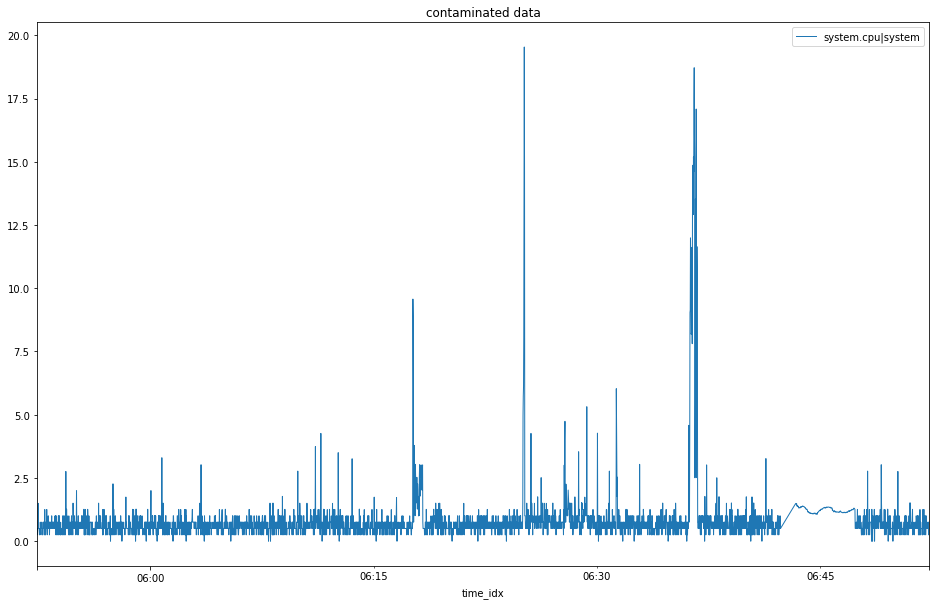

In [20]:
print(100 * "*")
print("preprocessing parameters")
print(100 * "*")
print("diffs_n ==", diffs_n) 
print("lags_n ==", lags_n)
print("smooth_n ==", smooth_n)
print(100 * "*")
print()

diffs_n = 1  # take differences
lags_n = 3  # include 3 lags in the feature vector
smooth_n = 3  # smooth the latest values to be included in the feature vector

# create train data
df_train = df.head(n_train)
print(100 * "*")
print("train_data DF ")
display(df_train)
print(100 * "*")
print()

# preprocess or 'featurize' the training data
train_data = preprocess_df(df_train, lags_n, diffs_n, smooth_n)
print(100 * "*")
print("train_data DF ")
display(train_data)
print(100 * "*")
print()

# create anomalous data
anomalous_len = int((len(df) - n_train) / 2)  # we pick half of our anomalous window to mess up
df_anomalous = df.tail(anomalous_len + anomalous_len)  # get the tail end of our raw data
df_anomalous = df_anomalous.head(anomalous_len)  # take the top part of it we want to mess with
df_anomalous[dims] = df_anomalous.sample(frac=1).values  # scramble the data
df_anomalous = df_anomalous.rolling(60).mean()*2  # apply a 60 seconds rolling avg to smooth it so that it looks much different
print(100 * "*")
print("df_anomalous DF ")
display(df_anomalous)
print(100 * "*")
print()

# preprocess or 'featurize' the anomalous data
anomalous_data = preprocess_df(df_anomalous, lags_n, diffs_n, smooth_n)
print(100 * "*")
print("anomalous_data DF ")
display(anomalous_data)
print(100 * "*")
print()

# append train data and anomalous data as 'contaminated' data
df_contaminated = df_train.append(df_anomalous).append(df.tail(anomalous_len)).interpolate(method='linear')
print(df_contaminated.plot(title='contaminated data', figsize=(16,10), lw=1))
print(100 * "*")
print("anomalous_data DF ")
display(df_contaminated)
print(100 * "*")
print()

# preprocess or 'featurize' the contaminated data
contaminated_data = preprocess_df(df_contaminated, lags_n, diffs_n, smooth_n)
print(100 * "*")
print("contaminated_data DF ")
display(df_contaminated)
print(100 * "*")
print()


In [90]:
def anomaly_scores(pca, X):
    """Given a fitted pca model and some X feature vectors, compute an anomaly score as the sum of weighted euclidean distance between each sample to the
    hyperplane constructed by the selected eigenvectors. 
    """
    return np.sum(cdist(X, pca.components_) / pca.explained_variance_ratio_, axis=1).ravel()


def experiment_with_pca():
    # if n_components BETWEEN 0.0 and 0.99 - explained variance by N number of components. The components could be from 1 to MAX components
    # Experimenting with the n_components parameter
    for n_comps in [0.8, 0.95, 1,2]:
      pca = PCA(n_components=n_comps)

      # scale based on training data
      scaler = StandardScaler()
      scaler.fit(train_data)

      # fit model
      pca.fit(scaler.transform(train_data))

      # print Attributes
      print(100 * "=")
      print(f"RUN n_components == {n_comps}")
      print(100 * "=")
      print("pca.components_ : \n", pca.components_)  # based on the variables you have in the train_df
      print("pca.explained_variance_", pca.explained_variance_)
      print("pca.explained_variance_ratio_", pca.explained_variance_ratio_) # this will sum up to 1 if all components are used (in that case n_components == 4). Otherwise shows the epxlained variance by component 1, component 2 and so on
      print("pca.n_components_", pca.n_components_)
      print(100 * "*")
      print()

      ## Calculate Anomaly scores steps
      ########################################################################
      ### BACKGROUND - anomaly_scores(pca, X)
      ## cdist(X, pca.components_) # calculate distance, where :
      # X == scaler.transform(train_data) | all training data rows
      # pca == Attributes from the fitted PCA model
      ########################################################################


      # Distance between X (taining_df) and the pca.components_
      print(100 * "*")
      print("Distance between X (taining_df) and the pca.components_")
      print(100 * "*")
      print(cdist(scaler.transform(train_data), pca.components_))
      print(100 * "*")
      print()

      # Weighted euclidean distance between X (taining_df) and the pca.components_
      print(100 * "*")
      print("Weighted distance between X (taining_df) and the pca.components_")
      print(100 * "*")
      print(cdist(scaler.transform(train_data), pca.components_) / pca.explained_variance_ratio_) 
      print(100 * "*")
      print()

      print(100 * "*")
      print("Size of data ==", len(np.sum(cdist(scaler.transform(train_data), pca.components_) / pca.explained_variance_ratio_, axis=1).ravel()))
      print(100 * "*")
      print()

      # compute an anomaly score as the sum of weighted euclidean distance between each sample to the hyperplane constructed by the selected eigenvectors (if n_components == 1 it equals the previous command)
      print(100 * "*")
      print("anomaly score as the sum of weighted euclidean distance")
      print(np.sum(cdist(scaler.transform(train_data), pca.components_) / pca.explained_variance_ratio_, axis=1).ravel()) 
      print(100 * "*")

experiment_with_pca()

RUN n_components == 0.8
pca.components_ : 
 [[ 0.48617242  0.51345196  0.51344274  0.48618928]
 [-0.57997761 -0.4045734   0.40479708  0.57972896]]
pca.explained_variance_ [2.63873508 0.61107953]
pca.explained_variance_ratio_ [0.65946344 0.15271886]
pca.n_components_ 2
****************************************************************************************************

****************************************************************************************************
Distance between X (taining_df) and the pca.components_
****************************************************************************************************
[[1.78007572 1.19793075]
 [1.55537569 1.81101322]
 [1.66078457 1.81458438]
 ...
 [1.22474032 0.89626821]
 [1.33608326 1.16540213]
 [1.57003396 1.11171647]]
****************************************************************************************************

****************************************************************************************************
Weighted dis

### FINAL | DEMO model

****************************************************************************************************
DEMO n_components == 2
****************************************************************************************************
pca.components_ : 
 [[ 0.48617242  0.51345196  0.51344274  0.48618928]
 [-0.57997761 -0.4045734   0.40479708  0.57972896]]
pca.explained_variance_ [2.63873508 0.61107953]
pca.explained_variance_ratio_ [0.65946344 0.15271886]
pca.n_components_ 2
****************************************************************************************************

****************************************************************************************************
df_train_scores | anomaly_scores 
2994


,anomaly_score
time_idx,
2022-08-16 05:52:27,10.543305
2022-08-16 05:52:28,14.217025
2022-08-16 05:52:29,14.400250
2022-08-16 05:52:30,9.832657
2022-08-16 05:52:31,11.595365
...,...
2022-08-16 06:42:16,12.396564
2022-08-16 06:42:17,10.008040
2022-08-16 06:42:18,7.725923


****************************************************************************************************

****************************************************************************************************
df_train_scores_min ==  4.080098616400669
df_train_scores_max ==  215.1552253189296
****************************************************************************************************

****************************************************************************************************
NORMALIZED df_train_scores | anomaly_scores 
2994


,anomaly_score
time_idx,
2022-08-16 05:52:27,0.030620
2022-08-16 05:52:28,0.048025
2022-08-16 05:52:29,0.048893
2022-08-16 05:52:30,0.027254
2022-08-16 05:52:31,0.035605
...,...
2022-08-16 06:42:16,0.039400
2022-08-16 06:42:17,0.028085
2022-08-16 06:42:18,0.017273


df_train_scores_min ==  0.0
df_train_scores_max ==  1.0
****************************************************************************************************

****************************************************************************************************
df_contaminated_scores | anomaly_scores 
3594


,anomaly_score
time_idx,
2022-08-16 05:52:27,0.030620
2022-08-16 05:52:28,0.048025
2022-08-16 05:52:29,0.048893
2022-08-16 05:52:30,0.027254
2022-08-16 05:52:31,0.035605
...,...
2022-08-16 06:52:16,0.023473
2022-08-16 06:52:17,0.032996
2022-08-16 06:52:18,0.037468


****************************************************************************************************



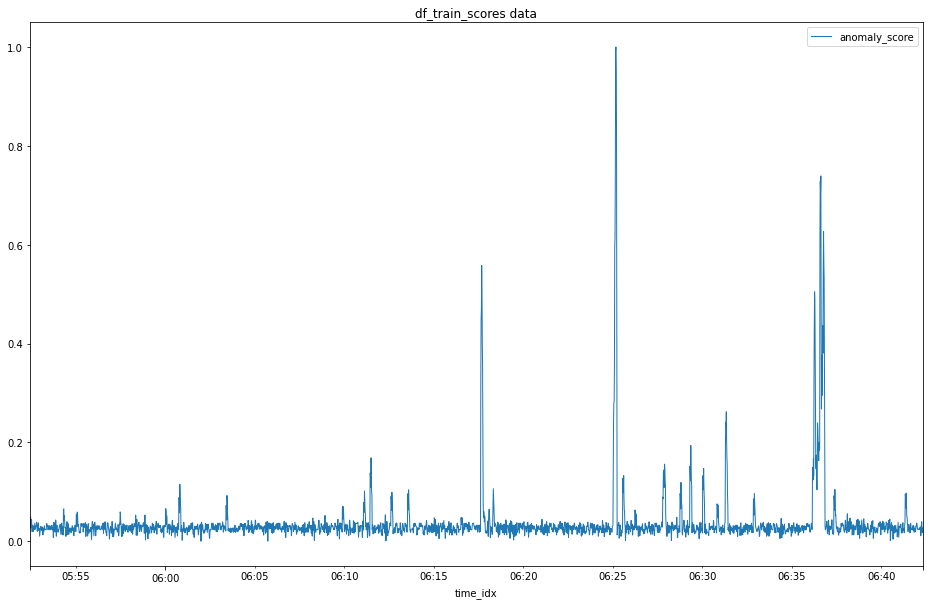

In [111]:
########################
# build PCA model
########################

pca = PCA(n_components=2)

# scale based on training data
scaler = StandardScaler()
scaler.fit(train_data)

# fit model
pca.fit(scaler.transform(train_data))

print(100 * "*")
print(f"DEMO n_components == {2}")
print(100 * "*")
print("pca.components_ : \n", pca.components_)  # based on the variables you have in the train_df
print("pca.explained_variance_", pca.explained_variance_)
print("pca.explained_variance_ratio_", pca.explained_variance_ratio_) # this will sum up to 1 if all components are used (in that case n_components == 4). Otherwise shows the epxlained variance by component 1, component 2 and so on
print("pca.n_components_", pca.n_components_)
print(100 * "*")
print()


# get anomaly scores for training data
train_scores = anomaly_scores(pca, scaler.transform(train_data))
df_train_scores = pd.DataFrame(train_scores, columns=['anomaly_score'], index=train_data.index)
df_train_scores_min = df_train_scores.min()
df_train_scores_max = df_train_scores.max()

print(100 * "*")
print("df_train_scores | anomaly_scores ")
print(len(df_train_scores))
display(df_train_scores)
print(100 * "*")
print()

print(100 * "*")
print("df_train_scores_min == ", df_train_scores_min[0])
print("df_train_scores_max == ", df_train_scores_max[0])
print(100 * "*")
print()

# normalize anomaly scores on based training data
# MIN/MAX normalization so that all values stay between 0 and 1
df_train_scores = ( df_train_scores - df_train_scores_min ) / ( df_train_scores_max - df_train_scores_min )
print(100 * "*")
print("NORMALIZED df_train_scores | anomaly_scores ")
print(len(df_train_scores))
display(df_train_scores)
print("df_train_scores_min == ", df_train_scores.min()[0])
print("df_train_scores_max == ", df_train_scores.max()[0])
print(100 * "*")
print()

# score all contaminated data
contaminated_scores = anomaly_scores(pca, scaler.transform(contaminated_data))
df_contaminated_scores = pd.DataFrame(contaminated_scores, columns=['anomaly_score'], index=contaminated_data.index)

# normalize based on train data scores
df_contaminated_scores = ( df_contaminated_scores - df_train_scores_min ) / ( df_train_scores_max - df_train_scores_min )
print(100 * "*")
print("df_contaminated_scores | anomaly_scores ")
print(len(df_contaminated_scores))
display(df_contaminated_scores)
print(100 * "*")
print()

In [115]:
df_train

,system.cpu|system
time_idx,
2022-08-16 05:52:21,0.502513
2022-08-16 05:52:22,0.502513
2022-08-16 05:52:23,0.503778
2022-08-16 05:52:24,0.503778
2022-08-16 05:52:25,0.251889
...,...
2022-08-16 06:42:16,0.751880
2022-08-16 06:42:17,0.503778
2022-08-16 06:42:18,1.002506


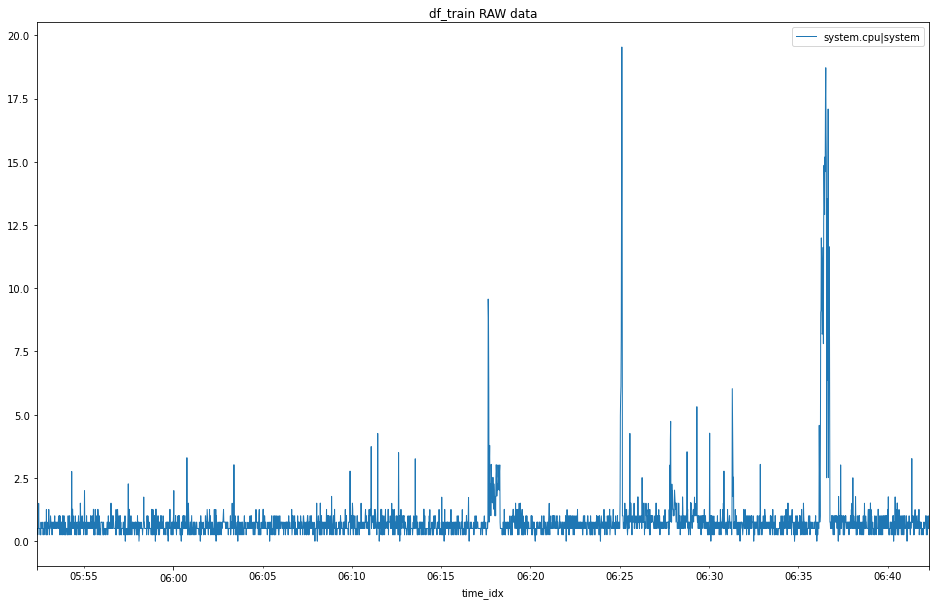

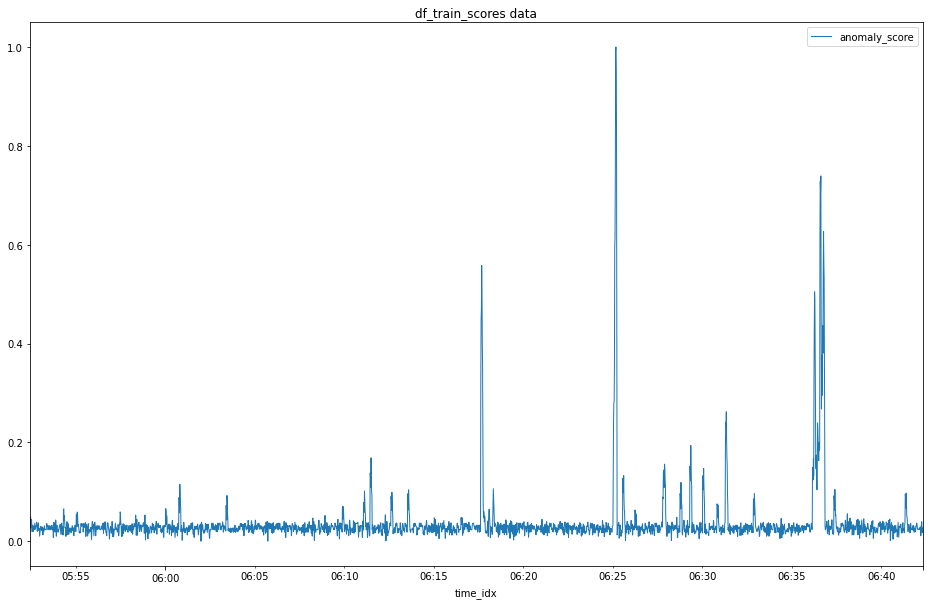

In [114]:
df_train.plot(title='df_train RAW data', figsize=(16,10), lw=1)
df_train_scores.plot(title='df_train_scores data', figsize=(16,10), lw=1)

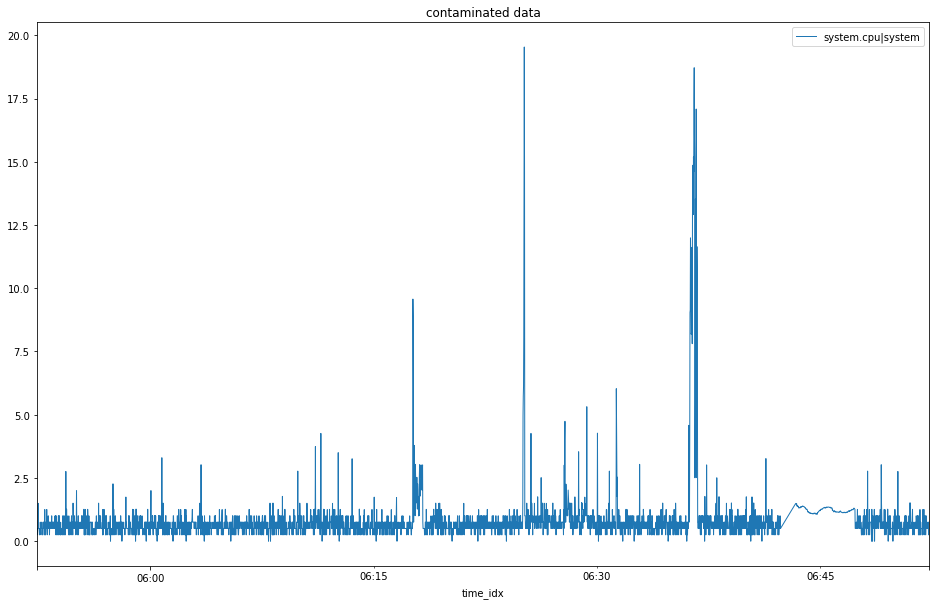

In [110]:
# add rolling mean of scores to smooth more
df_contaminated_scores_smoothed = df_contaminated_scores.rolling(15).mean()
df_contaminated.plot(title='contaminated data', figsize=(16,10), lw=1)

### PYOD outlier detection

In [121]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 134 kB 4.3 MB/s 
  Created wheel for pyod: filename=pyod-1.0.4-py3-none-any.whl size=165073 sha256=e71f2619b8124ca063e5ab473cb7a6aff5a837eb4468fe29e2ca73850048625d
  Stored in directory: /root/.cache/pip/wheels/3d/48/a8/87d61660791c7e6b0f5c3068da7fb17ade7fdc041e864fe053
Successfully built pyod


In [139]:
from pyod.models.pca import PCA as pyod_pca

In [208]:
## contamination thoughts

# cases TS | PRJ 
# training data : 30 days
days = 30
hours = 24
interval = 15

minutes_in_a_day = hours * 60
total_time_minutes_per_month = minutes_in_a_day * days # in minutes
data_points = total_time_minutes_per_month / interval

print("total_time_minutes_per_month == ", total_time_minutes_per_month)
print("TS data_points == ", data_points)


cases = data_points
# cases = 1000000               # timeseries records
# contamination = 0.1         # default - pyod
# contamination = 0.000000001 # adpcm current value

for contamination_value in [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000000001]:
    contamination = 0.1
    contamination = 0.000000001
    num_ = cases * contamination_value
    num_out = f"{num_:8f}"
    print(f"WHEN contamination_value == {contamination_value:8f} THEN number of outliers detected == ", num_out)

total_time_minutes_per_month ==  43200
TS data_points ==  2880.0
WHEN contamination_value == 0.100000 THEN number of outliers detected ==  288.000000
WHEN contamination_value == 0.010000 THEN number of outliers detected ==  28.800000
WHEN contamination_value == 0.001000 THEN number of outliers detected ==  2.880000
WHEN contamination_value == 0.000100 THEN number of outliers detected ==  0.288000
WHEN contamination_value == 0.000010 THEN number of outliers detected ==  0.028800
WHEN contamination_value == 0.000000 THEN number of outliers detected ==  0.000003


In [209]:
df_train = df.head(n_train)
anomalies_from_train = df_train[df_train["system.cpu|system"] > 10.0]
normal_from_train = df_train.iloc[:20]
test_df = pd.concat([normal_from_train, anomalies_from_train])
test_data = preprocess_df(test_df, lags_n, diffs_n, smooth_n)
# display(test_df)
display(test_data)

,system.cpu|system_lag0,system.cpu|system_lag1,system.cpu|system_lag2,system.cpu|system_lag3
time_idx,,,,
2022-08-16 05:52:27,4.219000e-04,1.259433e-03,8.354113e-02,4.219000e-04
2022-08-16 05:52:28,4.147901e-01,4.219000e-04,1.259433e-03,8.354113e-02
2022-08-16 05:52:29,8.375333e-04,4.147901e-01,4.219000e-04,1.259433e-03
2022-08-16 05:52:30,1.850372e-17,8.375333e-04,4.147901e-01,4.219000e-04
2022-08-16 05:52:31,3.312489e-01,1.850372e-17,8.375333e-04,4.147901e-01
2022-08-16 05:52:32,0.000000e+00,3.312489e-01,1.850372e-17,8.375333e-04
2022-08-16 05:52:33,8.332910e-02,0.000000e+00,3.312489e-01,1.850372e-17
2022-08-16 05:52:34,4.198333e-04,8.332910e-02,0.000000e+00,3.312489e-01
2022-08-16 05:52:35,8.375210e-02,4.198333e-04,8.332910e-02,0.000000e+00


In [304]:
pyod_model = pyod_pca(n_components=1, contamination=0.01)

# scale based on training data
scaler = StandardScaler()
scaler.fit(train_data)

# fit model
pyod_model.fit(scaler.transform(train_data))
print(pyod_model.explained_variance_ratio_)

# predictions using train data | just to explore the model and how it does predictions
predictions = pyod_model.predict(scaler.transform(train_data))
unique, counts = np.unique(predictions, return_counts=True)
print(unique)
print(counts)

# predict - TEST DATA
# scaler.fit(test_data)
# '''
# For each observation, tells whether or not
#     it should be considered as an outlier according to the
#     fitted model. 0 stands for inliers and 1 for outliers.
# '''
# predictions using test data
# print(pyod_model.predict(scaler.transform(test_data)))
# print(pyod_model.predict_proba(scaler.transform(test_data)))



[0.65946344]
[0 1]
[2964   30]


predictions
0    2964
1      30
Name: predictions, dtype: int64


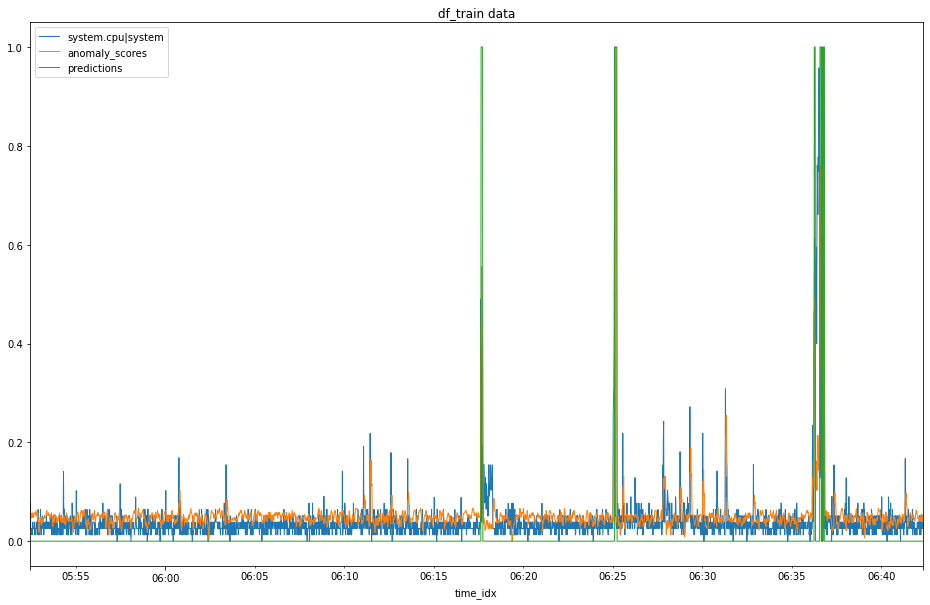

In [306]:
# Plotting 
predictions_df = pd.DataFrame(predictions, columns = ['predictions'])
predictions_df["time"] = df_train.iloc[6:].index
predictions_df = predictions_df.set_index("time")
predictions_df
print(predictions_df.groupby(['predictions'])['predictions'].count())

# Decision scores
anomaly_scores_df = pd.DataFrame(pyod_model.decision_scores_, columns = ['anomaly_scores'])
anomaly_scores_df["time"] = df_train.iloc[6:].index
anomaly_scores_df = anomaly_scores_df.set_index("time")

# Combine data frames
combined_ts_and_predictions_df = df_train.join(anomaly_scores_df)
combined_ts_and_predictions_df = combined_ts_and_predictions_df.iloc[6:].join(predictions_df)

# min/max normalization
final_df = (combined_ts_and_predictions_df-combined_ts_and_predictions_df.min())/(combined_ts_and_predictions_df.max()-combined_ts_and_predictions_df.min())
final_df.plot(title='df_train data', figsize=(16,10), lw=1)

In [293]:
final_df[final_df["predictions"] == 0]

,system.cpu|system,predictions,anomaly_scores
time_idx,,,
2022-08-16 05:52:27,0.025721,0.0,0.061867
2022-08-16 05:52:28,0.076585,0.0,0.053050
2022-08-16 05:52:29,0.025721,0.0,0.057186
2022-08-16 05:52:30,0.025721,0.0,0.057270
2022-08-16 05:52:31,0.025721,0.0,0.047052
...,...,...,...
2022-08-16 06:42:16,0.038484,0.0,0.050079
2022-08-16 06:42:17,0.025785,0.0,0.049727
2022-08-16 06:42:18,0.051312,0.0,0.040075


In [297]:
final_df[final_df["predictions"] == 1]

,system.cpu|system,predictions,anomaly_scores
time_idx,,,
2022-08-16 06:25:10,0.051441,1.0,0.992323
2022-08-16 06:25:11,0.051441,1.0,1.000000
2022-08-16 06:25:12,0.025656,1.0,0.972784
